# TensorFlow training of an artificial neural network to recognize handwritten digits in the MNIST dataset and export it to Oracle RDBMS
This notebook contains the preparation steps for the notebook MNIST_oracle_plsql.ipynb where you can find the steps for deploying a neural network serving engine in Oracle using PL/SQL   
Author: Luca.Canali@cern.ch - July 2016

## Initialize the environment and load the training set
Credits: the code for defining and training the neural network is adapted (with extensions) from the Google TensorFlow tutorial https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/mnist/mnist_softmax.py  

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Import data
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('data_dir', '/tmp/data/', 'Directory for storing data')

# Load training and test data sets with labels
mnist = input_data.read_data_sets(FLAGS.data_dir, one_hot=True)


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz



## Definition of the neural network:
- The following defines a basic feed forward neural network with one hidden layer
- Other standard techniques used are the definition of cross entropy as loss function and the use of gradient descent as optimizer


In [2]:
# define and initialize the tensors

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

W0 = tf.Variable(tf.truncated_normal([784, 100], stddev=0.1))
b0 = tf.Variable(tf.zeros([100])) 

W1 = tf.Variable(tf.truncated_normal([100, 10], stddev=0.1))
b1 = tf.Variable(tf.zeros([10])) 

# Feed forward neural network with one hidden layer

# y0 is the hidden layer with sigmoid activation
y0 = tf.sigmoid(tf.matmul(x, W0) + b0)

# y1 is the output layer (softmax)
# y1[n] is the predicted probability that the input image depicts number 'n'
y1 = tf.nn.softmax(tf.matmul(y0, W1) + b1)

# The the loss function is defined as cross_entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y1), reduction_indices=[1]))

# train the network using gradient descent
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cross_entropy)


In [3]:
# start a TensorFlow interactive session
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())


## Train the network
- The training uses 55000 images with labels
- It is performed over 30000 iterations using mini batch size of 100 images

In [4]:
batch_size = 100
train_iterations = 30000

# There are mnist.train.num_examples=55000 images in the train sample
# train in batches of 'batch_size' images at a time
# Repeat for 'train_iterations' number of iterations
# Training batches are randomly calculated as each new epoch starts

for i in range(train_iterations):
    batch = mnist.train.next_batch(100)
    train_data = feed_dict={x: batch[0], y_: batch[1]}
    train_step.run(train_data)

# Test the accuracy of the trained network
correct_prediction = tf.equal(tf.argmax(y1, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy of the trained network over the test images: %s" % 
      accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

Accuracy of the trained network over the test images: 0.9787


## Learning exercise: extract the tensors as 'manually' run the neural network scoring
In the following you can find an example of how to manually run the neural network scoring in Python using numpy. This is intended as an example to further the understanding of how the scoring engine works and opens the way for the next steps, that is the implementation of the scoring engine for Oracle using PL/SQL (see also the notebook MNIST_oracle_plsql.ipynb)

In [6]:
# There are 2 matrices and 2 vectors used in this neural network:
W0_matrix=W0.eval()
b0_array=b0.eval()
W1_matrix=W1.eval()
b1_array=b1.eval()

print ("W0 is matrix of size: %s " % (W0_matrix.shape,) )
print ("b0 is array of size:  %s " % (b0_array.shape,) )
print ("W1 is matrix of size: %s " % (W1_matrix.shape,) )
print ("b1 is array of size:  %s " % (b1_array.shape,) )


W0 is matrix of size: (784, 100) 
b0 is array of size:  (100,) 
W1 is matrix of size: (100, 10) 
b1 is array of size:  (10,) 


## Extracting the test images and labels as numpy arrays

In [7]:
testlabels=tf.argmax(mnist.test.labels,1).eval()
testimages=mnist.test.images

print ("testimages is matrix of size: %s " % (testimages.shape,) )
print ("testlabels is array of size:  %s " % (testlabels.shape,) )


testimages is matrix of size: (10000, 784) 
testlabels is array of size:  (10000,) 


## Example of how to run the neural network "manually" using the tensor values extracted into numpy arrays

In [8]:
import numpy as np

def softmax(x):
    """Compute the softmax function on a numpy array"""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def sigmoid(x):
    """Compute the sigmoid function on a numpy array"""
    return (1 / (1 + np.exp(-x)))

testimage=testimages[0]
testlabel=testlabels[0]

hidden_layer = sigmoid(np.dot(testimage, W0_matrix) + b0_array)
predicted = np.argmax(softmax(np.dot(hidden_layer, W1_matrix) + b1_array))

print ("image label %d, predicted value by the neural network: %d" % (testlabel, predicted))

image label 7, predicted value by the neural network: 7


## Visual test that the predicted value is indeed correct

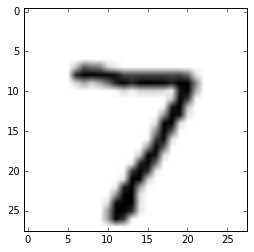

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(testimage.reshape(28,28), cmap='Greys')

## Transfer of the tensors and test data into Oracle tables

For the following you should have access to a (test) Oracle database. This procedure has been tested with Oracle 11.2.0.4 and 12.1.0.2 on Linux.
To keep the test isolated you can create a dedicated user (suggested name, mnist) for the data transfer, as follows:
<code>
### From a DBA account (for example the user system) execute:
SQL> create user mnist identified by mnist default tablespace users quota unlimited on users;
SQL> grant connect, create table, create procedure to mnist;
SQL> grant read, write on directory DATA_PUMP_DIR to mnist;
</code>

### These are the tables that will be used in the following code to transfer the tensors and testdata: 
<code>
SQL> connect mnist/mnist@ORCL
SQL> create table tensors(name varchar2(20), val_id number, val binary_float, primary key(name, val_id));
SQL> create table testdata(image_id number, label number, val_id number, val binary_float, primary key(image_id, val_id));
</code>

Open the connection to the database using cx_Oracle:
(for tips on how to install and use of cx_Oracle see also https://github.com/LucaCanali/Miscellaneous/tree/master/Oracle_Jupyter)

In [12]:
import cx_Oracle
ora_conn = cx_Oracle.connect('mnist/mnist@dbserver:1521/orcl.cern.ch')
cursor = ora_conn.cursor()

Transfer the matrixes W0 and W1 into the table tensors (which must be precreated as described above)

In [13]:
i = 0
sql="insert into tensors values ('W0', :val_id, :val)"
for column in W0_matrix:
    array_values = []
    for element in column:
        array_values.append((i, float(element)))
        i += 1
    cursor.executemany(sql, array_values)

ora_conn.commit()

i = 0
sql="insert into tensors values ('W1', :val_id, :val)"
for column in W1_matrix:
    array_values = []
    for element in column:
        array_values.append((i, float(element)))
        i += 1
    cursor.executemany(sql, array_values)

ora_conn.commit()

Transfer the vectors b0 and b1 into the table "tensors" (the table is expected to exist on the DB, create it using the SQL described above)

In [14]:
i = 0
sql="insert into tensors values ('b0', :val_id, :val)"
array_values = []
for element in b0_array:
    array_values.append((i, float(element)))
    i += 1
cursor.executemany(sql, array_values)

i = 0
sql="insert into tensors values ('b1', :val_id, :val)"
array_values = []
for element in b1_array:
    array_values.append((i, float(element)))
    i += 1
cursor.executemany(sql, array_values)

ora_conn.commit()

Transfer the test data with images and labels into the table "testdata" (the table is expected to exist on the DB, create it using the SQL described above)

In [15]:
image_id = 0
array_values = []
sql="insert into testdata values (:image_id, :label, :val_id, :val)"
for image in testimages:
    val_id = 0
    array_values = []
    for element in image:
        array_values.append((image_id, testlabels[image_id], val_id, float(element)))
        val_id += 1
    cursor.executemany(sql, array_values)
    image_id += 1

ora_conn.commit()

## Export the neural network tensors and test data

This will create a datapump export of the testdata_array and tensors_array tables into the destination DATA_PUMP_DIR 
(by default on $ORACLE_HOME/rdbms/log). Note if note executed earlier, run:
<code>
SQL> grant read, write on directory DATA_PUMP_DIR to mnist;
</code>

### From the command line as Oracle export the tables in a datapump dump file:
<code><b>
expdp mnist/mnist tables=testdata,tensors directory=DATA_PUMP_DIR dumpfile=MNIST_tables.dmp
</b></code>

### This ends the preparation of the network
### Please move on to the instructions for deploying the scoring engine in Oracle, see MNIST_oracle_plsql.ipynb